In [13]:
import numpy as np
import pandas as pd
import country_converter as coco
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
cc = coco.CountryConverter()

In [14]:
actual_outcomes = pd.read_csv("../data/Analysis/data/tables/acd.csv") 

# pick relevant years
ground_truth = actual_outcomes[(actual_outcomes["year"] >= 2001) & (actual_outcomes["year"]<= 2009)]

ground_truth

baseline_preds = pd.read_csv("predictions_baseline_2001_2009.csv") 
baseline_preds

,un_region,v2x_libdem_b,minor_actual,minor_count_country_years,prob_minor,major_actual,major_count_country_years,prob_major
0,Australia and New Zealand,2,0.0,9,1.000000,0.0,8,0.888889
1,Australia and New Zealand,2,1.0,0,0.000000,1.0,1,0.111111
2,Caribbean,0,0.0,16,0.941176,0.0,17,1.000000
3,Caribbean,0,1.0,1,0.058824,1.0,0,0.000000
4,Caribbean,1,0.0,10,1.000000,0.0,10,1.000000
...,...,...,...,...,...,...,...,...
75,Western Asia,1,1.0,11,0.550000,1.0,0,0.000000
76,Western Asia,2,0.0,9,0.500000,0.0,18,1.000000
77,Western Asia,2,1.0,9,0.500000,1.0,0,0.000000
78,Western Europe,2,0.0,18,1.000000,0.0,18,1.000000


In [15]:
# old_preds = pd.read_stata("../data/CountryYearResults.dta") 

In [16]:
hegre_preds = pd.read_csv("../data/Analysis/data/tables/predictions_2001_2009.csv")
hegre_preds["gwcode"] = hegre_preds["gwcode"].astype(int)
hegre_preds['alpha3'] = cc.pandas_convert(series=hegre_preds.gwcode, to='ISO3', src='gwcode')
hegre_preds = hegre_preds[hegre_preds.alpha3 != 'not found']
hegre_preds['un_region'] = cc.pandas_convert(series=hegre_preds.alpha3, to='UNREGION', src='ISO3')
hegre_preds

316 not found in GWcode
345 not found in GWcode
678 not found in GWcode
816 not found in GWcode


,gwcode,year,minor,major,combined,alpha3,un_region
0,2,2001.0,0.015111,0.000889,0.016000,USA,Northern America
1,2,2002.0,0.012667,0.000111,0.012778,USA,Northern America
2,2,2003.0,0.010556,0.003556,0.014111,USA,Northern America
3,2,2004.0,0.014556,0.004222,0.018778,USA,Northern America
4,2,2005.0,0.019667,0.006333,0.026000,USA,Northern America
...,...,...,...,...,...,...,...
1513,950,2005.0,0.000333,0.000222,0.000556,FJI,Melanesia
1514,950,2006.0,0.000333,0.000333,0.000667,FJI,Melanesia
1515,950,2007.0,0.000444,0.000111,0.000556,FJI,Melanesia
1516,950,2008.0,0.000222,0.000222,0.000444,FJI,Melanesia


In [17]:
un_region = hegre_preds.groupby(['un_region']).agg({
    'minor': 'mean',  # Replace 'mean' with the appropriate aggregation function
    'major': 'mean'
}).reset_index()

In [18]:
# Step 1: Create a DataFrame with all unique country-year pairs from both DataFrames
all_country_years = pd.concat([
    hegre_preds[['gwcode', 'year']].drop_duplicates(),
    ground_truth[['gwcode', 'year']].drop_duplicates()
]).drop_duplicates().reset_index(drop=True)

# Step 2: Update the ground truth to include all country-years, filling missing values with 0
# It assumes that 'minor_conflict' and 'major_conflict' are the columns in your ground_truth DataFrame
all_ground_truth = pd.merge(all_country_years, ground_truth, on=['gwcode', 'year'], how='left').fillna(0)

# Step 3: Merge this updated ground truth with the predictions DataFrame
eval_df = pd.merge(hegre_preds, all_ground_truth, on=['gwcode', 'year'])


In [19]:
eval_df

,gwcode,year,minor,major,combined,alpha3,un_region,intensity_level,minor_actual,major_actual,either_actual
0,2,2001.0,0.015111,0.000889,0.016000,USA,Northern America,2.0,0.0,1.0,1.0
1,2,2002.0,0.012667,0.000111,0.012778,USA,Northern America,1.0,1.0,0.0,1.0
2,2,2003.0,0.010556,0.003556,0.014111,USA,Northern America,2.0,0.0,1.0,1.0
3,2,2004.0,0.014556,0.004222,0.018778,USA,Northern America,1.0,1.0,0.0,1.0
4,2,2005.0,0.019667,0.006333,0.026000,USA,Northern America,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1478,950,2005.0,0.000333,0.000222,0.000556,FJI,Melanesia,0.0,0.0,0.0,0.0
1479,950,2006.0,0.000333,0.000333,0.000667,FJI,Melanesia,0.0,0.0,0.0,0.0
1480,950,2007.0,0.000444,0.000111,0.000556,FJI,Melanesia,0.0,0.0,0.0,0.0
1481,950,2008.0,0.000222,0.000222,0.000444,FJI,Melanesia,0.0,0.0,0.0,0.0


In [20]:
# Calculate metrics for Minor Conflicts
threshold = 0.5

y_true = eval_df['either_actual']
# y_pred = eval_df['combined'] > threshold 
y_pred = (eval_df['minor'] > threshold) | (eval_df['major'] > threshold)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Minor Conflict):")
print(cm)

# Accuracy, Precision, Recall, F1 Score
accuracy_minor = accuracy_score(y_true, y_pred)
precision_minor = precision_score(y_true, y_pred)
recall_minor = recall_score(y_true, y_pred)
f1_minor = f1_score(y_true, y_pred)

fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])  # FP / (TN + FP)
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)

print(f"Accuracy: {accuracy_minor}")
print(f"Precision: {precision_minor}")
print(f"Recall: {recall_minor}")
print(f"F1 Score: {f1_minor}")

print(f"False Positive Rate: {fpr}")
print(f"True Positive Rate: {tpr}")

Confusion Matrix (Minor Conflict):
[[1232   13]
 [ 155   83]]
Accuracy: 0.8867161159811193
Precision: 0.8645833333333334
Recall: 0.3487394957983193
F1 Score: 0.49700598802395207
False Positive Rate: 0.010441767068273093
True Positive Rate: 0.3487394957983193


In [24]:
cm

array([[1232,   13],
       [ 155,   83]], dtype=int64)

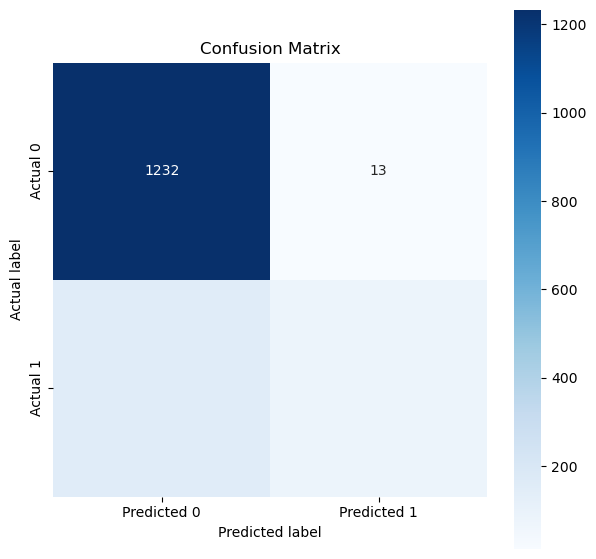

In [27]:
fig, ax = plt.subplots(figsize=(7,7)) # You can adjust the size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

ROC AUC (Minor Conflict): 0.9227683844622185


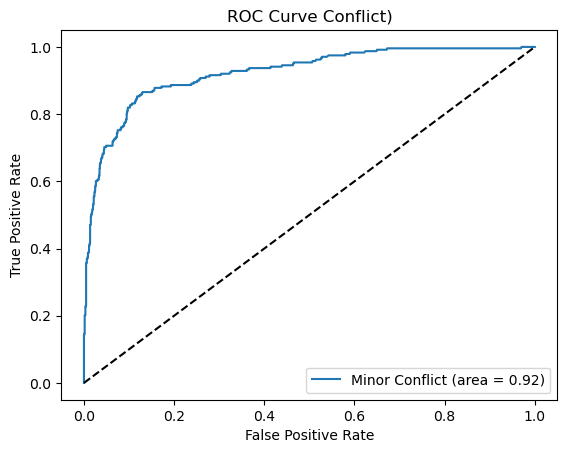

In [22]:
# For ROC AUC and ROC Curve, you need the probabilities, not the binary predictions
y_prob= eval_df['combined'] # Assuming this column exists with probabilities

# ROC AUC
roc_auc_minor = roc_auc_score(y_true, y_prob)
print(f"ROC AUC (Minor Conflict): {roc_auc_minor}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Minor Conflict (area = {roc_auc_minor:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Conflict)')
plt.legend(loc="lower right")
plt.show()


In [23]:
# Define your specific threshold
specific_threshold = 0.5

# Find the index of the closest threshold
closest_threshold_index = np.argmin(np.abs(thresholds - specific_threshold))

# Get the FPR and TPR for the closest threshold
specific_fpr = fpr[closest_threshold_index]
specific_tpr = tpr[closest_threshold_index]

print(f'For threshold = {specific_threshold}, FPR = {specific_fpr}, TPR = {specific_tpr}')

For threshold = 0.5, FPR = 0.02971887550200803, TPR = 0.6050420168067226
